In [1]:
import numpy as np
import corner

## Generate fake data

In [ ]:
def random_covariance_matrix(n_dim, min_correlation, max_correlation):
    """ Generate a random covariance matrix with the specified dimensions and correlation range.
    """
    # Initialize a matrix of zeros
    A = np.zeros((n_dim, n_dim))

    # Populate the matrix with random correlations within the specified range
    for i in range(n_dim):
        for j in range(i, n_dim):
            if i == j:
                A[i, j] = 1  # Variance of 1 along the diagonal
            else:
                A[i, j] = A[j, i] = np.random.uniform(min_correlation, max_correlation)

    # Ensure the matrix is positive definite
    A = A.T.dot(A)
    return A

In [2]:
n_dim = 14
min_correlation = -1
max_correlation = 1

A_cov = random_covariance_matrix(n_dim, min_correlation, max_correlation)
A_mean = np.random.uniform(-2, 2, n_dim)  # Random mean offset

# Train and val sets
X_samples = np.random.multivariate_normal(A_mean, A_cov, 100000)
X_samples_val = np.random.multivariate_normal(A_mean, A_cov, 1000)

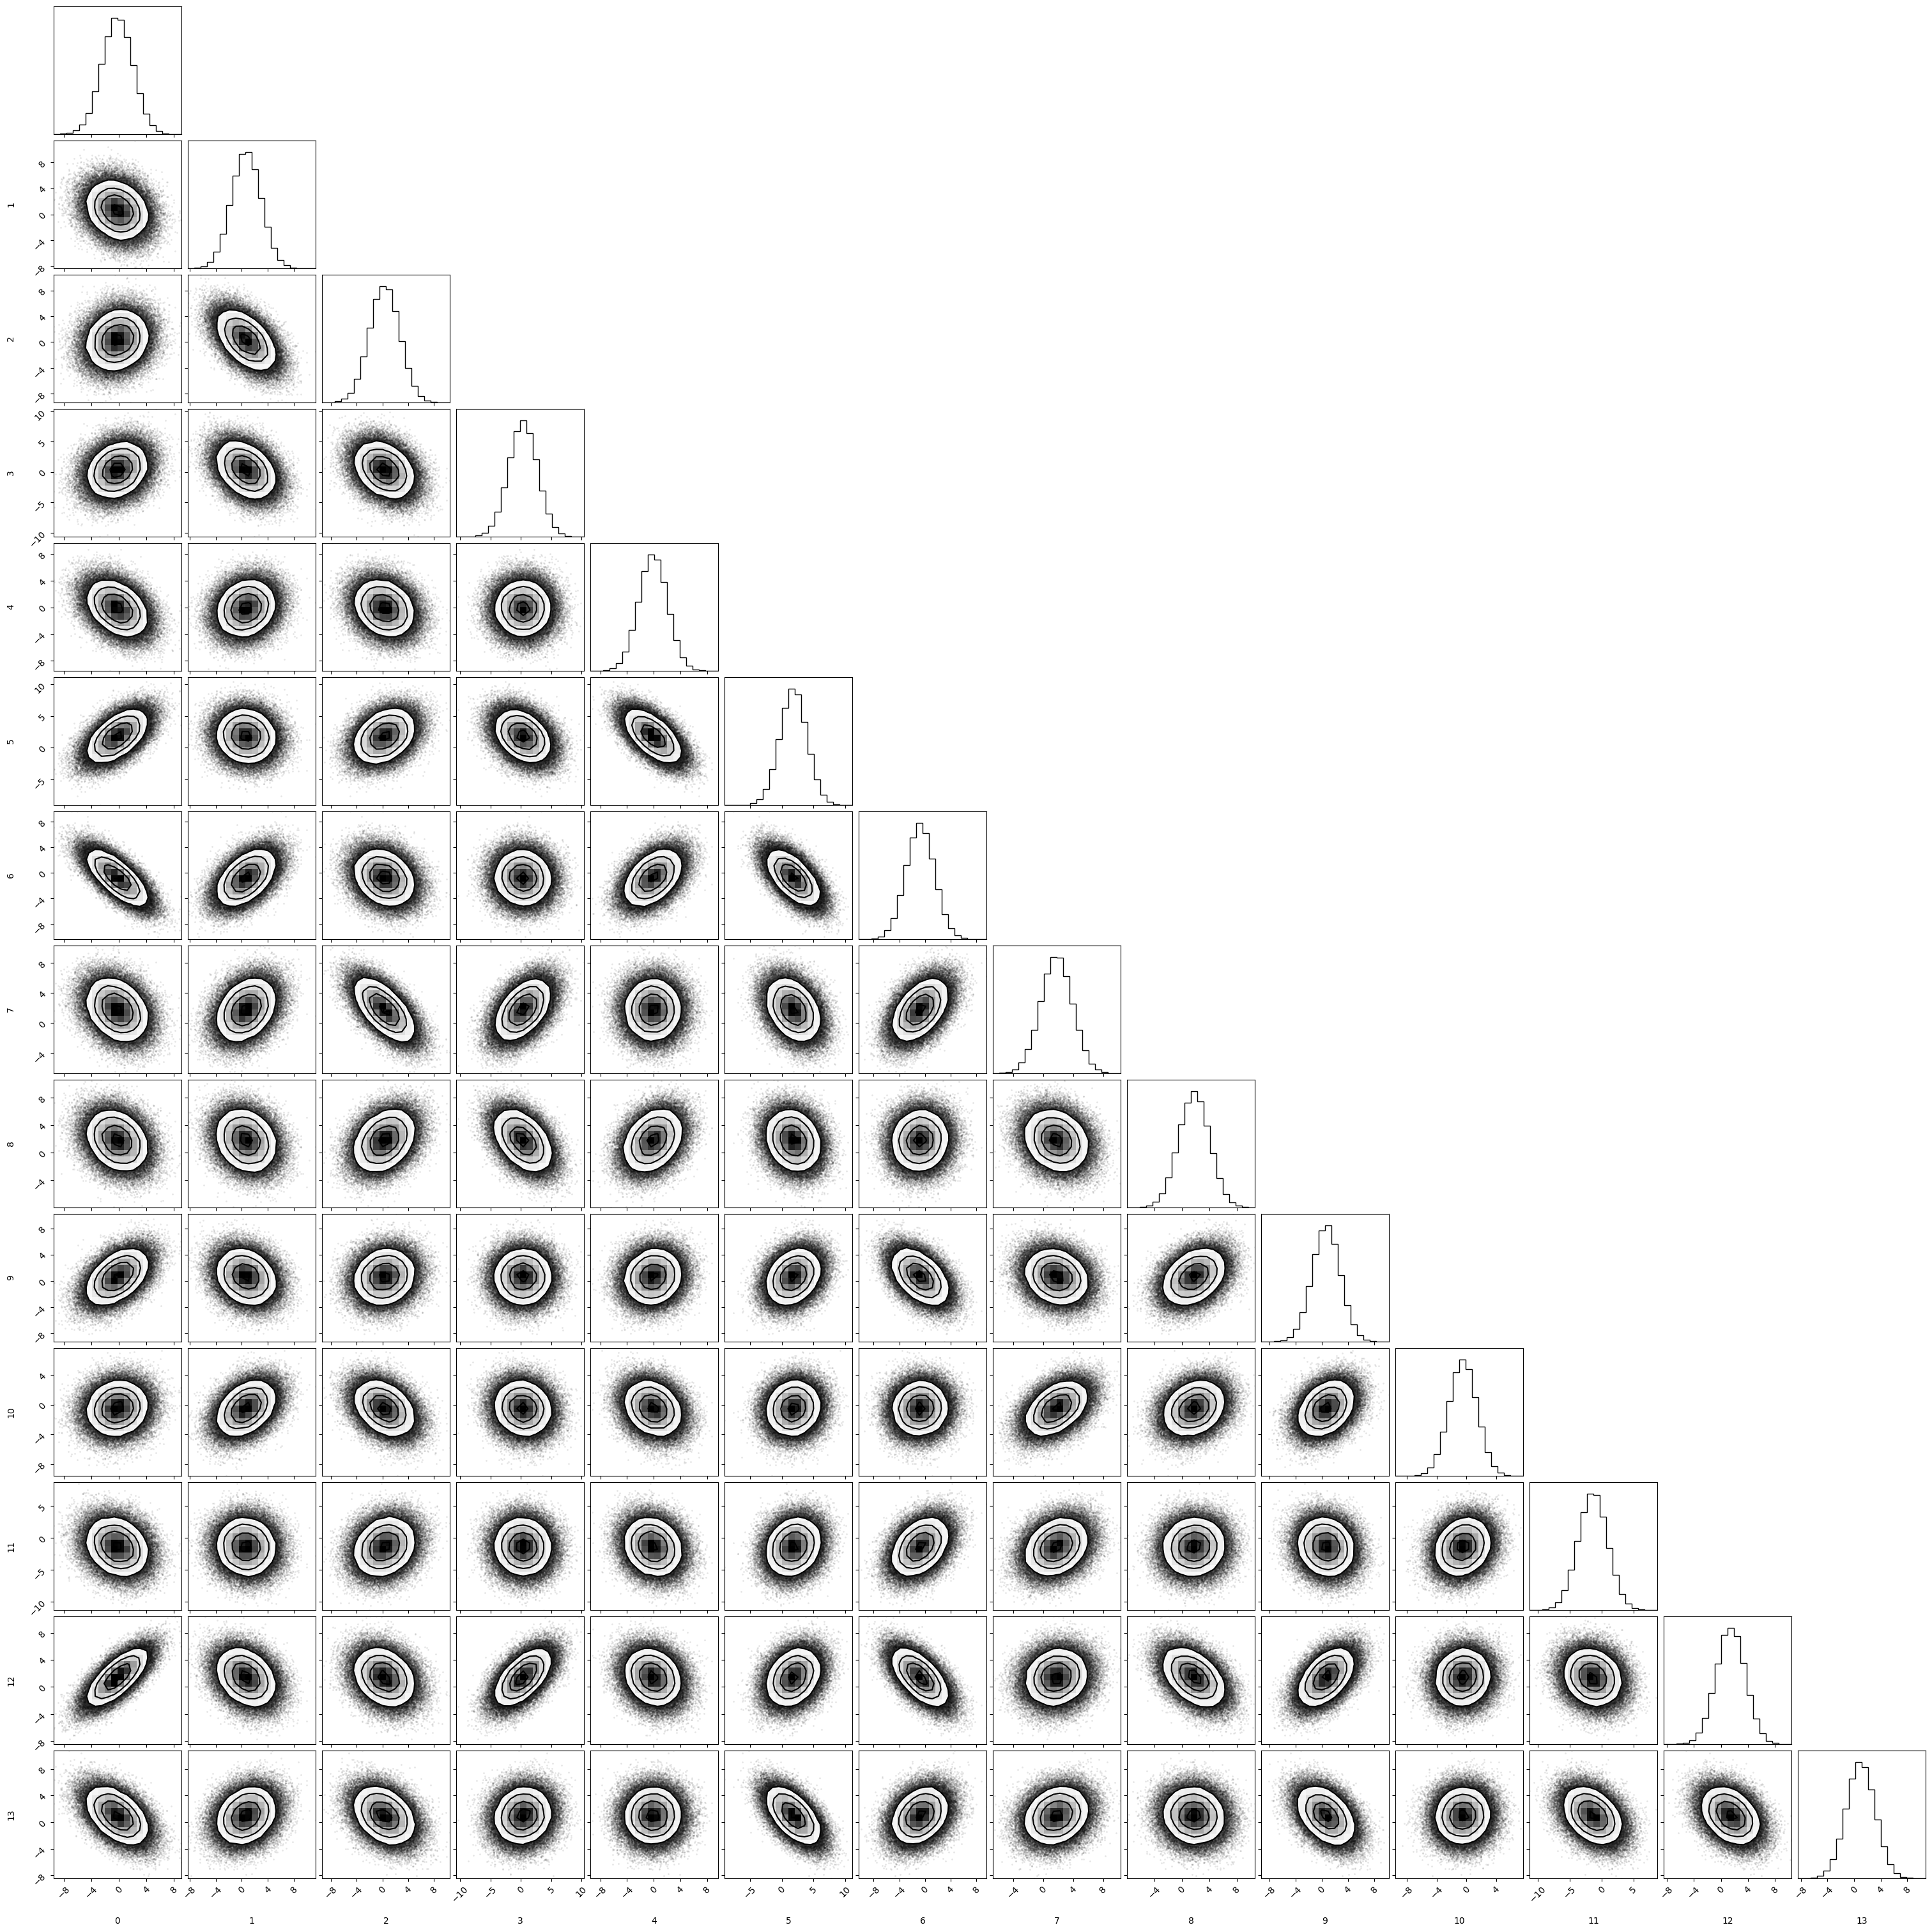

In [3]:

corner.corner(X_samples, labels=[str(i) for i in range(n_dim)]);

## Train density estimators

In [4]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [5]:
X_samples = torch.tensor(X_samples, dtype=torch.float32)
X_samples_val = torch.tensor(X_samples_val, dtype=torch.float32)

In [6]:
def get_flow(d_in=2, d_hidden=32, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [13]:
def train_flow(X, flow, batch_size=64, n_steps=5001, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        loss = -flow.log_prob(X[idxs,:]).mean()
        
        loss.backward()
        optimizer.step()

    return -flow.log_prob(X_samples_val[:100]).mean()


n_dataset_samples = [64, 100, 500, 1000, 2000, 4000, 8000, 10000, 50000]

val_losses = []
for n_dataset_sample in n_dataset_samples:
    flow = get_flow(d_in=n_dim, d_hidden=64, n_layers=4)
    val_loss = train_flow(X_samples[:n_dataset_sample], flow, batch_size=64, n_steps=10001, lr=1e-3)
    val_losses.append(val_loss.detach().numpy())

  0%|          | 0/10001 [00:00<?, ?it/s]

100%|██████████| 10001/10001 [00:29<00:00, 336.71it/s]


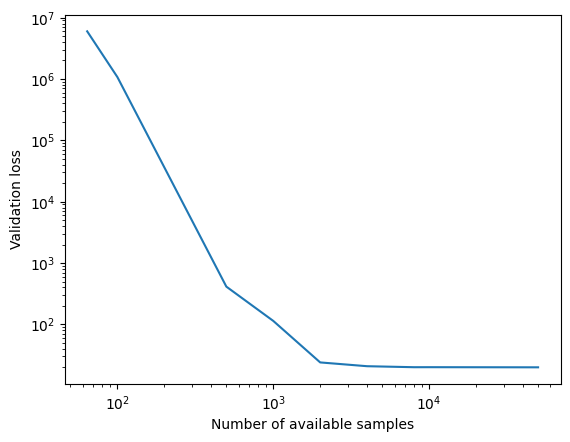

In [17]:
import matplotlib.pyplot as plt

plt.plot(n_dataset_samples, np.array(val_losses))
plt.xlabel('Number of available samples')
plt.ylabel('Validation loss')
plt.yscale('log')
plt.xscale('log')